In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Price_Year 2018.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width
window_width = 30  # Adjusted window width for experimentation

# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2018-10-24')
val_mask = (dates >= pd.to_datetime('2018-10-24')) & (dates < pd.to_datetime('2018-11-28'))
test_mask = dates >= pd.to_datetime('2018-11-28')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



FileNotFoundError: [Errno 2] No such file or directory: 'Gold Price_Year 2018.csv'

In [ ]:
print(X_train)


Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM.pt
[LSTM] Test Loss: 0.001219
[LSTM] Test MAPE: 10.50%
[LSTM] Test Accuracy: 89.50%

Training GRU model...
Loaded existing model for GRU from best_model_GRU.pt
[GRU] Test Loss: 0.001142
[GRU] Test MAPE: 10.20%
[GRU] Test Accuracy: 89.80%

Training RNN model...
Loaded existing model for RNN from best_model_RNN.pt
[RNN] Test Loss: 0.001297
[RNN] Test MAPE: 10.45%
[RNN] Test Accuracy: 89.55%

Training CNN model...
Loaded existing model for CNN from best_model_CNN.pt
[CNN] Test Loss: 0.005033
[CNN] Test MAPE: 21.94%
[CNN] Test Accuracy: 78.06%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM.pt
[EnhancedLSTM] Test Loss: 0.002578
[EnhancedLSTM] Test MAPE: 15.88%
[EnhancedLSTM] Test Accuracy: 84.12%


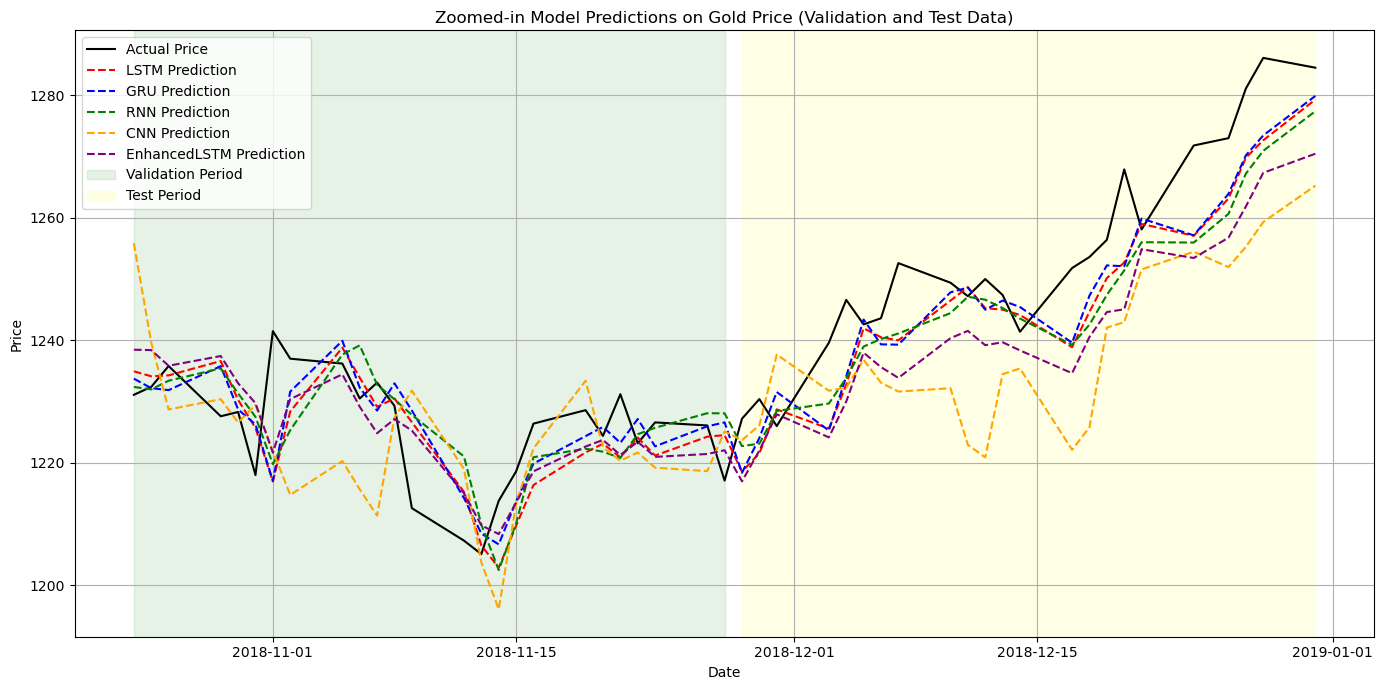

In [58]:

# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 800
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")

    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
print(type(zoom_dates))

<class 'numpy.ndarray'>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation and test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# List of your model names (keys in all_results)
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Define consistent colors for each model
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------------------------
# 1) Create masks for even and odd days
# ------------------------------------------------
# zoom_dates is an array of Timestamp or datetime objects.
# We'll categorize them by "day of month is even" (training)
# and "day of month is odd" (validation).
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])  # Even day
validation_mask = ~training_mask  # Odd day

# Extract the training subset (even days)
zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

# Extract the validation subset (odd days)
zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

# ------------------------------------------------
# 2) Loop over polynomial degrees
# ------------------------------------------------
poly_degrees = range(1, 75)  # polynomial degrees from 1 to 74

for n in poly_degrees:
    # Only plot the figure for multiples of 5 (like your example)
    if n % 5 == 0:
        # =========================
        # A) Training Set Plot
        # =========================
        plt.figure(figsize=(10, 5))

        # Plot the actual training data points
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')

        # Fit polynomial to training ACTUAL data
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        # Evaluate the polynomial on the same training set
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        # Plot polynomial curve of training actual data
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Training)')

        # Fit and plot polynomials for each model’s TRAINING data
        for model_name in model_names:
            # Get this model's full predictions, then pick the training subset
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]

            # Fit polynomial to training predictions
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)

            # Plot polynomial curve
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.gcf().autofmt_xdate()
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

        # Show the training plot
        plt.show()
        plt.pause(0.1)

        # =========================
        # B) Validation Set Plot
        # =========================
        plt.figure(figsize=(10, 5))

        # Plot the actual validation data points
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')

        # Fit polynomial to validation ACTUAL data
        coeff_actual_val = np.polyfit(date_numeric_val, zoom_actual_val, n)
        # Evaluate the polynomial on the same validation set
        poly_actual_val = np.polyval(coeff_actual_val, date_numeric_val)
        # Plot polynomial curve of validation actual data
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Validation)')

        # Fit and plot polynomials for each model’s VALIDATION data
        for model_name in model_names:
            # Get this model's full predictions, then pick the validation subset
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_val = y_pred_combined[validation_mask]

            # Fit polynomial to validation predictions
            coeff_pred_val = np.polyfit(date_numeric_val, y_pred_val, n)
            poly_pred_val = np.polyval(coeff_pred_val, date_numeric_val)

            # Plot polynomial curve
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.gcf().autofmt_xdate()
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')




        # Show the validation plot
        plt.show()
        plt.pause(0.1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation and test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# List of your model names (keys in all_results)
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Define consistent colors for each model
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------------------------
# 1) Create masks for even and odd days
# ------------------------------------------------
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])  # Even day
validation_mask = ~training_mask  # Odd day

# Extract the training subset (even days)
zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

# Extract the validation subset (odd days)
zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

# ------------------------------------------------
# 2) Loop over polynomial degrees
# ------------------------------------------------
poly_degrees = range(1, 75)  # polynomial degrees from 1 to 74

for n in poly_degrees:
    # Only plot the figure for multiples of 5 (like your example)
    if n % 5 == 0:
        # =========================
        # A) Training Set Plot
        # =========================
        plt.figure(figsize=(10, 6))

        # Plot the actual training data points
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')

        # Fit polynomial to training ACTUAL data
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        # Evaluate the polynomial on the same training set
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        # Plot polynomial curve of training actual data
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Training)')

        # Fit and plot polynomials for each model’s TRAINING data
        for model_name in model_names:
            # Get this model's full predictions, then pick the training subset
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]

            # Fit polynomial to training predictions
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)

            # Plot polynomial curve
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()

        # Show the training plot
        plt.show()
        plt.pause(0.1)

        # =========================
        # B) Validation Set Plot
        # =========================
        plt.figure(figsize=(10, 6))

        # Plot the actual validation data points
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')

        # Evaluate the training polynomial on validation dates
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        # Plot polynomial curve of validation actual data
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Validation)')

        # Evaluate the training polynomial for each model’s VALIDATION data
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]

            # Use the polynomial coefficients from the training set
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)

            # Plot polynomial curve
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.gcf().autofmt_xdate()
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

        # Show the validation plot
        plt.show()
        plt.pause(0.1)


NameError: name 'val_dates' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation and test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# List of your model names (keys in all_results)
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Define consistent colors for each model
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Polynomial degrees to try
poly_degrees = range(1, 70)  # 1 through 16

# Loop over each polynomial degree
for n in poly_degrees:
    plt.figure(figsize=(10, 6))

    # -------------------------------------
    # 1. Plot the ACTUAL data and its fit
    # -------------------------------------
    # Plot the actual data points
    plt.plot(zoom_dates, zoom_actual, 'k*', label='Actual Data')

    # Fit polynomial to ACTUAL data
    coeff_actual = np.polyfit(date_numeric, zoom_actual, n)
    # Evaluate the polynomial fit
    poly_actual = np.polyval(coeff_actual, date_numeric)
    # Plot polynomial curve of actual data
    plt.plot(zoom_dates, poly_actual, 'r-', label=f'{n}-degree Fit (Actual)')

    # -------------------------------------------------
    # 2. Plot the polynomial fits for each MODEL's data
    # -------------------------------------------------
    for model_name in model_names:
        # Concatenate validation+test predictions for this model
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))

        # Fit polynomial to predicted data
        coeff_pred = np.polyfit(date_numeric, y_pred_combined, n)
        poly_pred = np.polyval(coeff_pred, date_numeric)

        # Plot only the polynomial fit for each model (no raw points)
        plt.plot(
            zoom_dates,
            poly_pred,
            '--',
            label=f'{n}-degree Fit ({model_name})'
            
        )

    plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
    plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
    plt.title(f'Polynomial Fits (Degree = {n})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend(loc='best')

    # Format the date axis nicely
    plt.gcf().autofmt_xdate()

    # Show the plot and pause briefly
    plt.show()
    plt.pause(0.1)


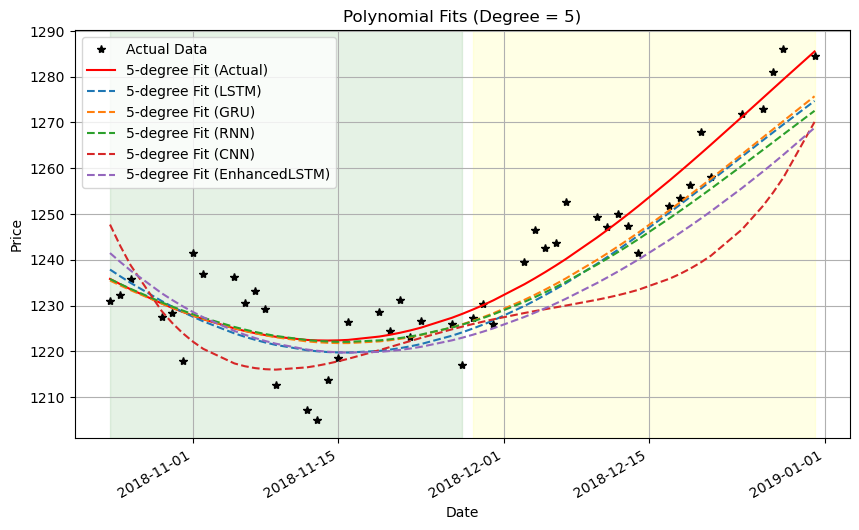

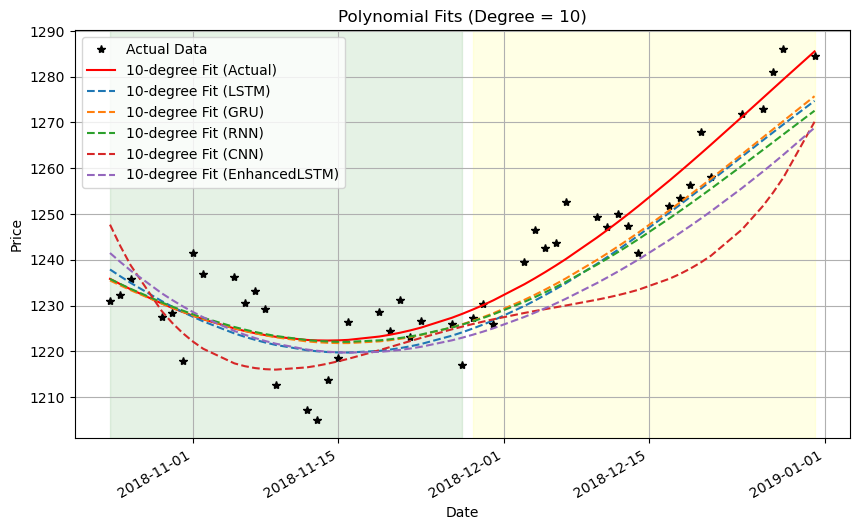

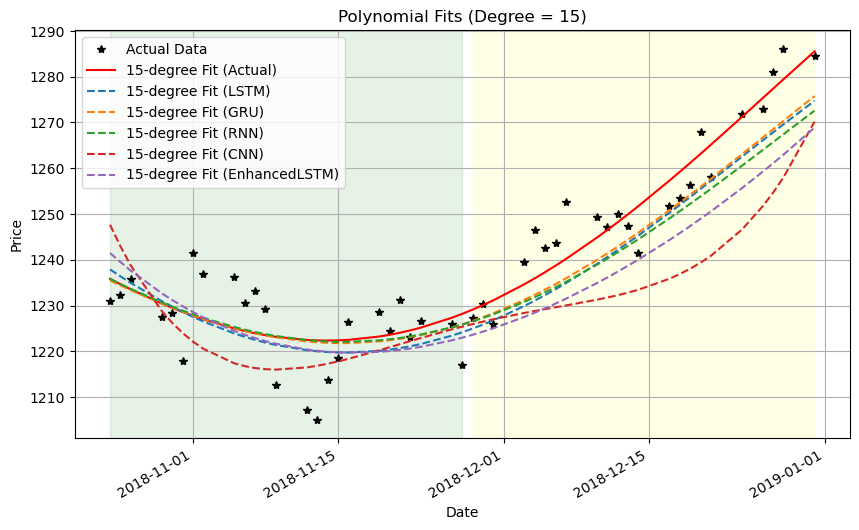

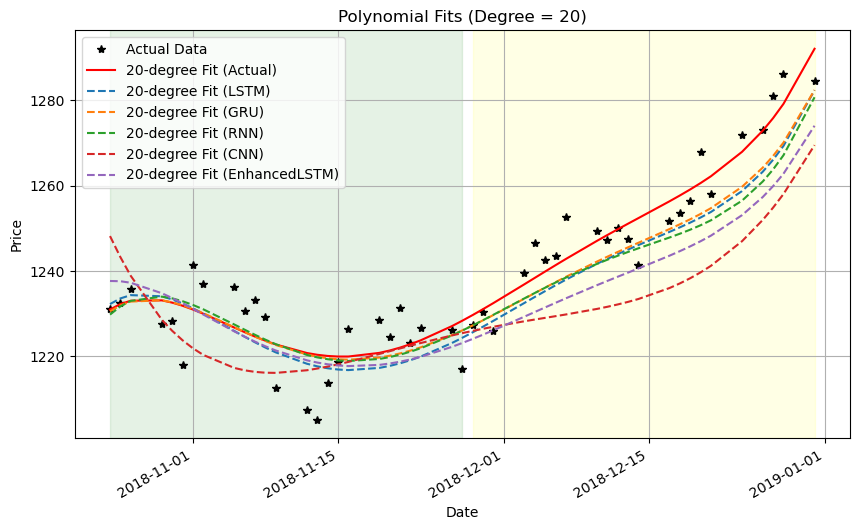

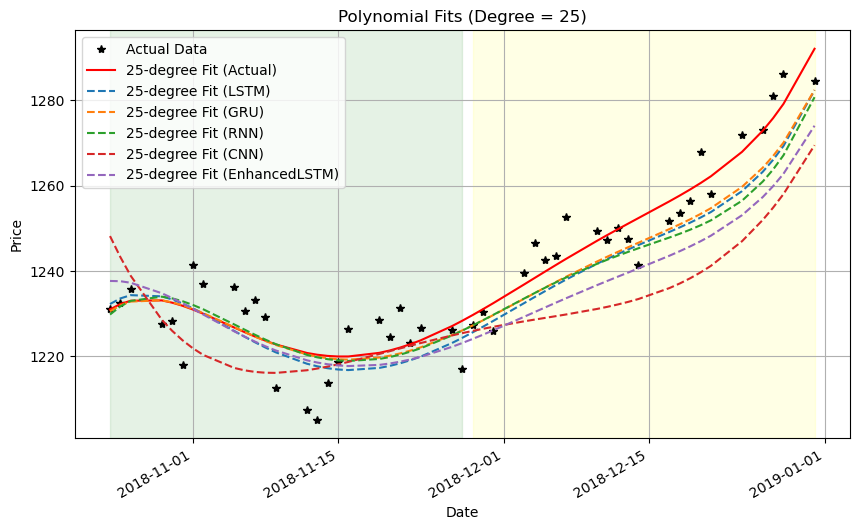

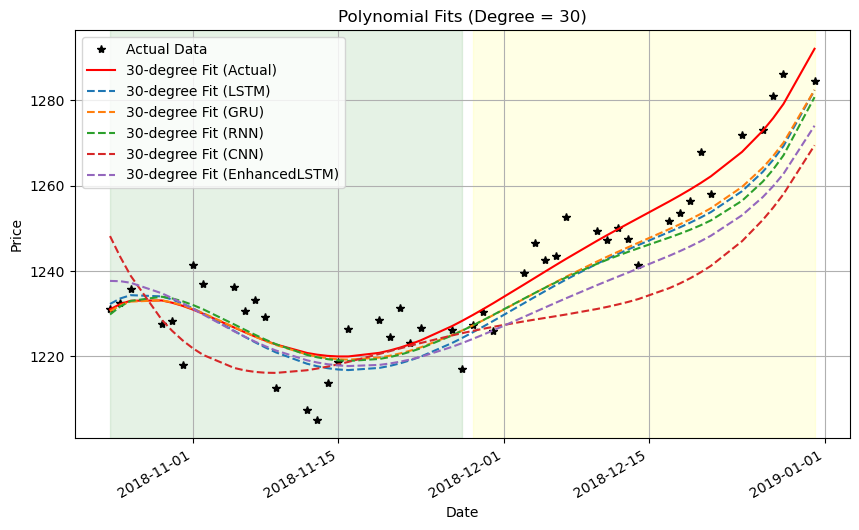

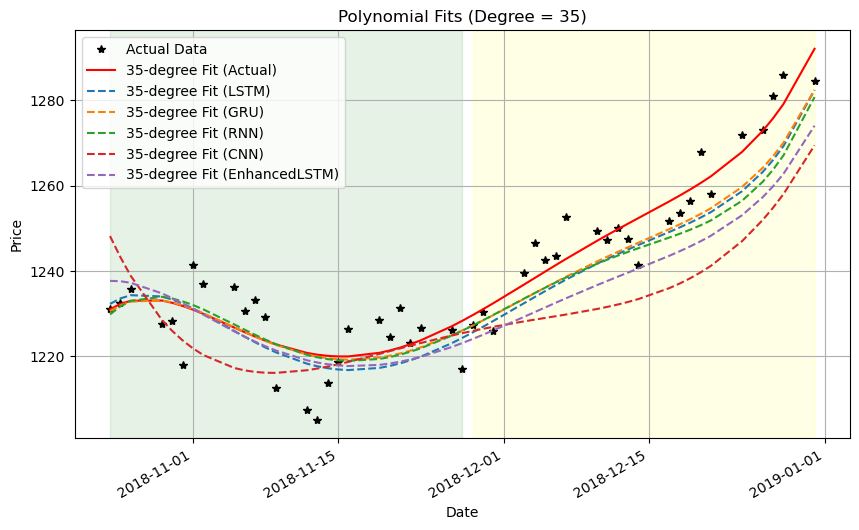

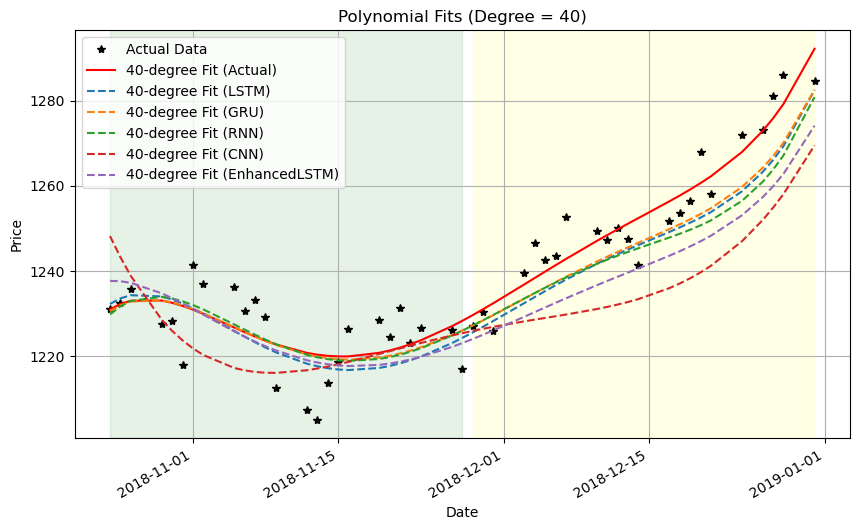

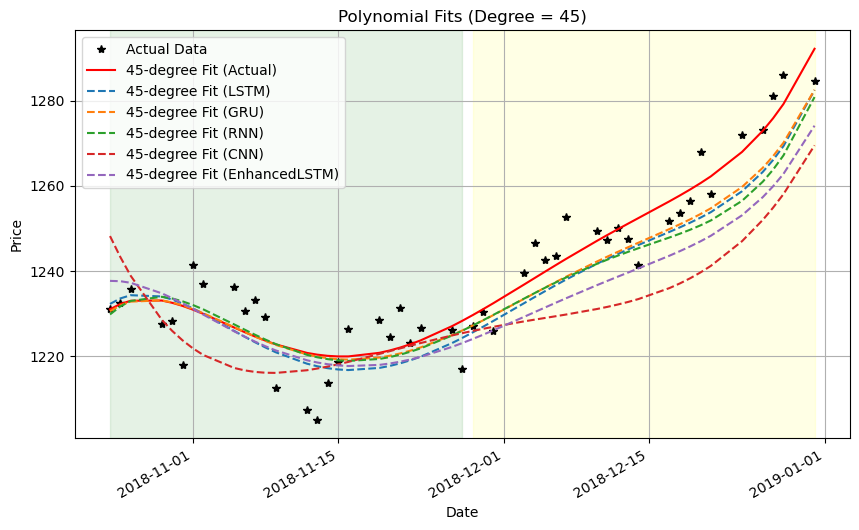

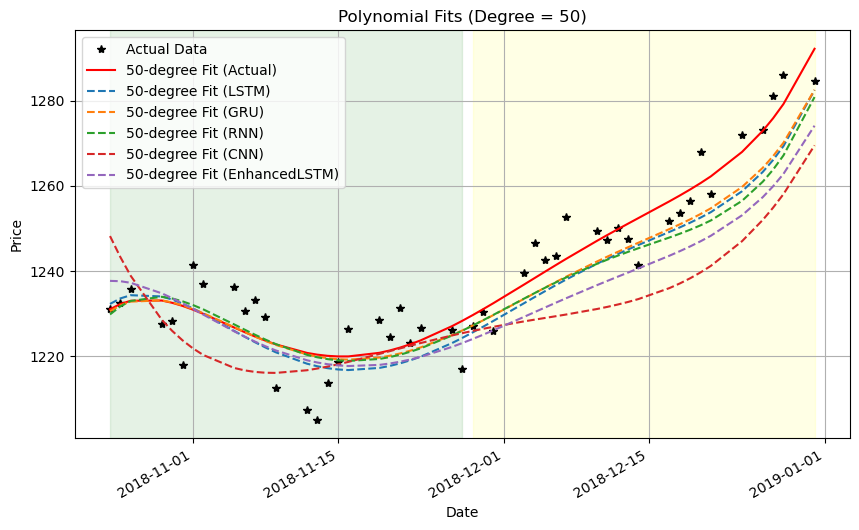

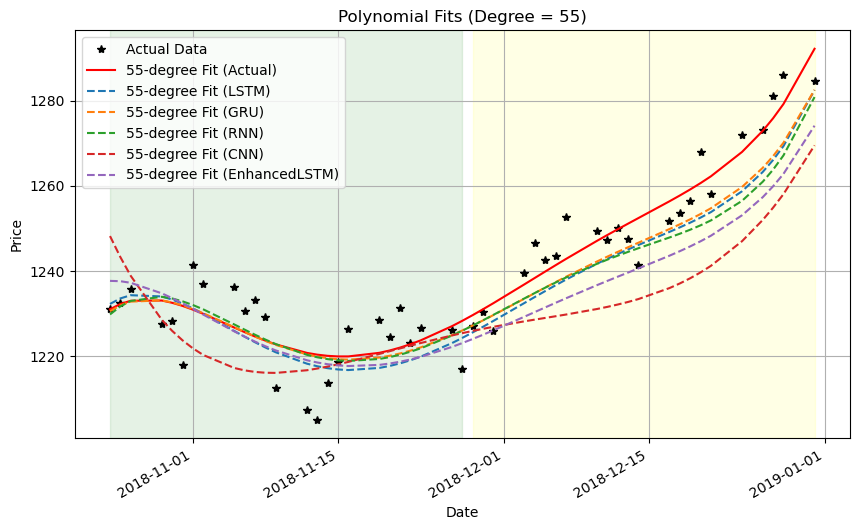

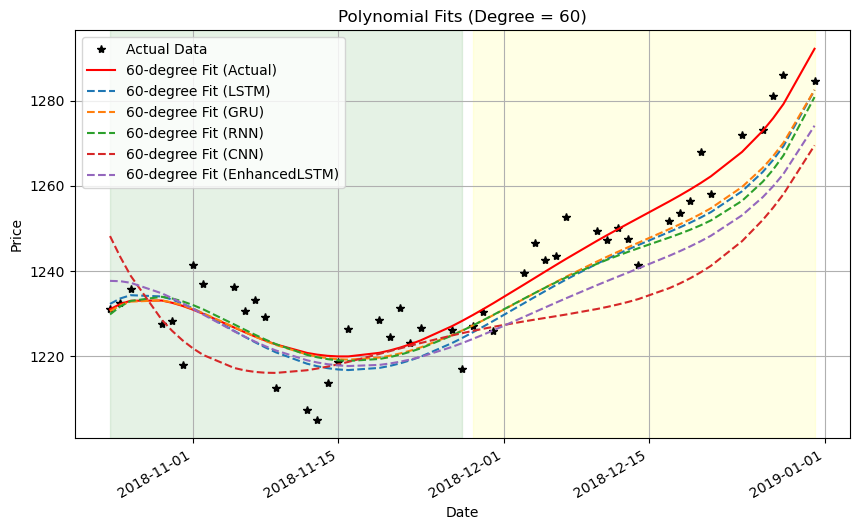

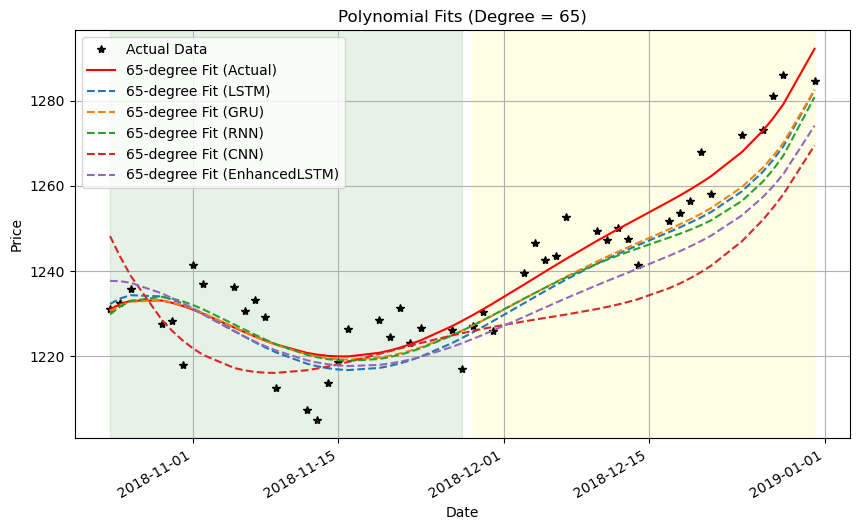

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation and test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# List of your model names (keys in all_results)
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Define consistent colors for each model
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Instead of plotting *every* degree, we only plot multiples of 10
poly_degrees = range(1, 70)  # 1 through 80

for n in poly_degrees:
    # We do polynomial fitting for all degrees
    # but only plot the figure for multiples of 10
    if n % 5 == 0:
        plt.figure(figsize=(10, 6))

        # -------------------------------------
        # 1. Plot the ACTUAL data and its fit
        # -------------------------------------
        # Plot the actual data points
        plt.plot(zoom_dates, zoom_actual, 'k*', label='Actual Data')

        # Fit polynomial to ACTUAL data
        coeff_actual = np.polyfit(date_numeric, zoom_actual, n)
        # Evaluate the polynomial fit
        poly_actual = np.polyval(coeff_actual, date_numeric)
        # Plot polynomial curve of actual data
        plt.plot(zoom_dates, poly_actual, 'r-', label=f'{n}-degree Fit (Actual)')

        # -------------------------------------------------
        # 2. Plot the polynomial fits for each MODEL's data
        # -------------------------------------------------
        for model_name in model_names:
            # Concatenate validation+test predictions for this model
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))

            # Fit polynomial to predicted data
            coeff_pred = np.polyfit(date_numeric, y_pred_combined, n)
            poly_pred = np.polyval(coeff_pred, date_numeric)

            # Plot only the polynomial fit for each model (no raw points)
            plt.plot(
                zoom_dates,
                poly_pred,
                '--',
                label=f'{n}-degree Fit ({model_name})'
            )

        plt.title(f'Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

        # Format the date axis nicely
        plt.gcf().autofmt_xdate()

        # Show the plot and pause briefly
        plt.show()
        plt.pause(0.1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation and test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# List of your model names (keys in all_results)
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Define consistent colors for each model
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Instead of plotting *every* degree, we only plot multiples of 10
poly_degrees = range(1,75)  # 1 through 80

for n in poly_degrees:
    # We do polynomial fitting for all degrees
    # but only plot the figure for multiples of 10
    if n % 5 == 0:
        plt.figure(figsize=(10, 6))

        # -------------------------------------
        # 1. Plot the ACTUAL data and its fit
        # -------------------------------------
        # Plot the actual data points
        plt.plot(zoom_dates, zoom_actual, 'k*', label='Actual Data')

        # Fit polynomial to ACTUAL data
        coeff_actual = np.polyfit(date_numeric, zoom_actual, n)
        # Evaluate the polynomial fit
        poly_actual = np.polyval(coeff_actual, date_numeric)
        # Plot polynomial curve of actual data
        plt.plot(zoom_dates, poly_actual, color = 'black', label=f'{n}-degree Fit (Actual)')

        # -------------------------------------------------
        # 2. Plot the polynomial fits for each MODEL's data
        # -------------------------------------------------
        for model_name in model_names:
            # Concatenate validation+test predictions for this model
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))

            # Fit polynomial to predicted data
            coeff_pred = np.polyfit(date_numeric, y_pred_combined, n)
            poly_pred = np.polyval(coeff_pred, date_numeric)

            # Plot only the polynomial fit for each model (no raw points)
            plt.plot(
                zoom_dates,
                poly_pred,
                color=model_colors[model_name],
                linestyle = '--',
                label=f'{n}-degree Fit ({model_name})'
            )

        plt.title(f'Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

        # Format the date axis nicely
        plt.gcf().autofmt_xdate()

        # Show the plot and pause briefly
        plt.show()
        plt.pause(0.1)


In [ ]:
def polynomial_fitting_for_gold_price(max_degree=16):
    """
    Fits an n-th degree polynomial to the TRAINING portion of the gold price data,
    then predicts/plots the results for both validation and test sets.
    """
    # Convert each dates array (NumPy) into ordinal integers
    x_train = np.array([d.toordinal() for d in train_dates])
    x_val   = np.array([d.toordinal() for d in val_dates])
    x_test  = np.array([d.toordinal() for d in test_dates])
    zoom_dates = np.concatenate((val_dates, test_dates))
    x_val_test = np.array([d.toordinal() for d in zoom_dates])

    #linestyles = ['-', '--', '-.', ':', (0, (5, 1))]
    #colors = ['r', 'g', 'b', 'm', 'c']  # Add some colors for variety

    # Inverse-transform the scaled y-values to original price scale
    y_train_inv = inverse_transform(y_train_tensor.numpy())
    y_val_inv   = inverse_transform(y_val_tensor.numpy())
    y_test_inv  = inverse_transform(y_test_tensor.numpy())
    zoom_actual = np.concatenate((y_val_inv, y_test_inv))


    plt.figure(figsize=(14, 7))

    # Plot actual data
    plt.plot(val_dates,  y_val_inv,   'k*', label='Validation Actual')
    plt.plot(test_dates, y_test_inv,  'b*', label='Test Actual')

    for n in range(1, max_degree + 1):
        # Fit polynomial on training set only
        coeffs = np.polyfit(x_val_test, zoom_actual, deg=n)

        # Evaluate polynomial on validation and test sets
        y_val_pred  = np.polyval(coeffs, x_val)
        y_test_pred = np.polyval(coeffs, x_test)
        y_val_test_pred = np.polyval(coeffs, x_val_test)
        #style = linestyles[(n - 1) % len(linestyles)]
        #color = colors[(n - 1) % len(colors)]

        plt.plot(zoom_dates, y_val_test_pred, linestyle = '--', label=f'Degree {n}')

    # Plot polynomial predictions
    #plt.plot(val_dates,  y_val_pred,  'k--', label=f'Validation Poly (deg={n})')
    #plt.plot(test_dates, y_test_pred, 'b--', label=f'Test Poly (deg={n})')

    # Highlight the validation & test periods
    plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
    plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

    plt.title(f'Polynomial Fitting for Gold Price (Degrees 1 to {max_degree})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

polynomial_fitting_for_gold_price(max_degree=6)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def polynomial_fitting_demo(x, y, max_degree= 16):
    """
    Fits and plots polynomial curves from degree 1 up to `max_degree` 
    for data (x, y). Demonstrates how higher-degree polynomials behave.
    """
    plt.figure(figsize=(10, 8))

    # Plot the original noisy data once
    plt.scatter(x, y, color='black', marker='x', label='Noisy data')
    
    # Create an array for plotting smooth predictions
    # (Using more points than x to see a smoother curve)
    x_smooth = np.linspace(np.min(x), np.max(x), 300)

    for n in range(1, max_degree + 1):
        # Fit polynomial of degree n
        coeffs = np.polyfit(x, y, deg=n)

        # Evaluate polynomial at x_smooth
        y_smooth = np.polyval(coeffs, x_smooth)

        # Plot the polynomial’s prediction
        label_str = f'Degree {n}'
        plt.plot(x_smooth, y_smooth, label=label_str, linestyle='--')

    plt.title(f'Polynomial Fitting from Degree 1 to {max_degree}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.ylim([-2, 2])  # Adjust as needed based on your data range
    plt.grid(True)
    plt.show()

# Example usage:
# Suppose we have x, y in arrays. For instance:
x = np.linspace(0, 2*np.pi, 50)
y = np.sin(x) + 0.2*np.random.randn(50)
polynomial_fitting_demo(x, y, max_degree=8)


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x and y are defined arrays representing your data
# For example:



    # Convert each dates array (NumPy) into ordinal integers
x_train = np.array([d.toordinal() for d in train_dates])
x_val   = np.array([d.toordinal() for d in val_dates])
x_test  = np.array([d.toordinal() for d in test_dates])
zoom_dates = np.concatenate((val_dates, test_dates))
x_val_test = np.array([d.toordinal() for d in zoom_dates])

    #linestyles = ['-', '--', '-.', ':', (0, (5, 1))]
    #colors = ['r', 'g', 'b', 'm', 'c']  # Add some colors for variety

    # Inverse-transform the scaled y-values to original price scale
y_train_inv = inverse_transform(y_train_tensor.numpy())
y_val_inv   = inverse_transform(y_val_tensor.numpy())
y_test_inv  = inverse_transform(y_test_tensor.numpy())
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

for n in range(1, 17):
    # Fit an nth degree polynomial to the data
    p = np.polyfit(zoom_dates y, n)

    # Evaluate the polynomial at the points of our data
    y1 = np.polyval(p, x)

    # Create a subplot
    plt.subplot(3, 1, 1)

    # Plot the noisy data
    plt.plot(x, y, '*', label="Noisy Data")
    
    # Plot the polynomial fit
    plt.plot(x, y1, 'o', label=f"Polynomial Degree {n}")
    plt.ylim([-2, 2])

    # Add title, labels, and text
    plt.title('Training data and model predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    txt = f'Degree of polynomial = {n}'
    plt.text(7.5, 1.5, txt)

    # Show the plot and pause
    plt.legend()
    plt.pause(0.5)
    plt.clf()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3896773404.py, line 27)